# Entendimiento de los datos con PySpark - Luis Solier Sajami

## 1- Configuracion general


### 1.1- Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python necesarios

In [44]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
#from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport
#import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import to_date
from pyspark.sql.functions import date_format

Configuración del controlador e inicio de sesion Spark

In [2]:
path_jar_driver = '/home/luissolier/Documents/miso/ciclo-7/analisis-y-modelado-de-datos/tutoriales/entendimiento-datos/mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

23/08/23 19:05:44 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.1.41 instead (on interface enp46s0)
23/08/23 19:05:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/23 19:05:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/23 19:05:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/08/23 19:05:45 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
/home/luissolier/Documents/miso/ciclo-7/analisis-y-modelado-de-datos/tutoriales/entendimiento-datos/tutorial-env/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSe

In [4]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://localhost:3306/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = ''
db_psswd = ''

PATH='./'

### 1.2- Conexión a fuente de datos y acceso a los datos

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

### 1.3- Cargue de datos

In [13]:
sql_movimientos = 'WWImportersTransactional.movimientosCopia'
sql_tipos_transaccion = 'WWImportersTransactional.TiposTransaccion'

In [14]:
#Se cargan los dataframes desde la base de datos
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)
tipos_transaccion = obtener_dataframe_de_bd(db_connection_string, sql_tipos_transaccion, db_user, db_psswd)

## 2- Información dada por la organización relacionada con los datos

En esta actividad le recomendamos revisar el diccionario de datos suministrado y en particular la información relacionada con la tabla movimientosCopia. Si tienen alguna duda relacionada con esta tabla deben incluirla en las preguntas o aclaraciones que le entreguen al negocio. En relación a los datos Wide World Importers menciona:

- La cantidad máxima de productos movidos es 50 millones por transacción
- Existen 236.668 movimientos de producto realizados desde 2013
- Los movimientos están relacionados con 228.265 clientes
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
- Actualmente tenemos 13 proveedores

## 3- Perfilamiento de los datos
El perfilamiento se basa en varios aspectos: **entendimiento general** de los datos compartidos, validación de **reglas de negocio**, **análisis descriptivo** utilizando estadística descriptiva y diagramas para la visualización de los datos y **análisis de calidad**. El primero hace referencia a tener una comprensiòn global antes de entrar en los detalles, la segunda sobre las reglas, corresponden a especificaciones dadas por el negocio en relación con los datos, un ejemplo de regla de negocio dada es: "Todo producto de la canasta familiar debe tener un precio de IVA equivalente a 19%", dada esta regla de negocio, se debe revisar en los datos suministrados que no hayan valores de IVA menores a 19%. En el tercer aspecto, relacionado con el análisis descriptivo, se revisan estadísticas: mínimo, máximo, media, mediana, distribuciones de los datos, valores nulos, cardinalidad con el fin de comprender en mayor nivel de profundidad los datos compartidos.

### 3.1- Entendimiento general de datos

In [19]:
movimientos.show(10)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

In [17]:
tipos_transaccion.show(15)

+-----------------+---------------------+
|TipoTransaccionID|TipoTransaccionNombre|
+-----------------+---------------------+
|                2| Customer Credit Note|
|                3| Customer Payment ...|
|                4|      Customer Refund|
|                5|     Supplier Invoice|
|                6| Supplier Credit Note|
|                7| Supplier Payment ...|
|                8|      Supplier Refund|
|                9|       Stock Transfer|
|               10|          Stock Issue|
|               11|        Stock Receipt|
|               12| Stock Adjustment ...|
|               13|      Customer Contra|
+-----------------+---------------------+



Como puede observar en la tabla de movimientos tenemos **información realcionada con el cliente, proveedor y producto**. La información del cliente es su identificador ?_ClienteID_, el identificador del proveedor del producto _ProductoID_, el identificador del producto que fue extraido o agregado al inventario _ProductoID_, el identificador del tipo de transaccion vinculado al movimiento _TipoTransaccionID_ (Ej. 2.Customer Credit Note, 3. Customer Payment Received), el identificador de la orden de compra vinculado al movimiento _OrdenDeCompraID_, el identificador de la factura _InvoiceID_, la fecha de transaccion _FechaTransaccion_ y la cantidad del producto dentro del moviemiento _Cantidad_.

In [20]:
movimientos.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))

In [22]:
tipos_transaccion.schema

StructType(List(StructField(TipoTransaccionID,IntegerType,true),StructField(TipoTransaccionNombre,StringType,true)))

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [21]:
print((movimientos.count(), len(movimientos.columns)),(tipos_transaccion.count(), len(tipos_transaccion.columns)))

(204292, 9) (12, 2)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 204.292 movimientos y 12 tipo de movimientos y tenemos en total 11 variables a revisar de las cuales 7 son nùmericas asociadas a los movimientos y tipos de movimeinto, 4 son cadenas de caracteres.

### 3.2- Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, la primera asegura:

#### 3.2.1- La cantidad maxima de productos movidos es 50 millones por transaccion

Vemos que no es posible corroborar esta informacion dado que no existe un tabla que nos informe del monto por cada factura, adicional a ello la columna InvoiceID tiene valores duplicados.

In [25]:
movimientos.select("InvoiceID").distinct().show(10)

+---------+
|InvoiceID|
+---------+
|  30102.0|
|  39221.0|
|  28134.0|
|  50815.0|
|  51013.0|
|  26597.0|
|  68581.0|
|  42071.0|
|  33322.0|
|  67357.0|
+---------+
only showing top 10 rows



In [26]:
print(movimientos.select("InvoiceID").distinct().count())

51831


Asumiendo que la columna **_InvoiceID_** representa el monto total del movimiento, la regla tampoco seria cierta, ya que si obtenemos el valor maximo obtenido es 70510.

In [27]:
movimientos.agg({'InvoiceID': 'max'}).show()

+--------------+
|max(InvoiceID)|
+--------------+
|       70510.0|
+--------------+



La conclusion es entonces es que no se puede determinar si la regla es cierta o no, dado que no hay existe una tabla **Invoice** que nos brinde el monto asociado a cada movimiento.

#### 3.2.2- Existen 236.668 movimientos de producto realizados desde 2013

Vemos que la segunda regla que indica que existen 236668 movimientos no es cierta, ya que al hacer un conteo encontramos 204292 registros. Si revisamos los registros no duplicados obtenemos un total ade 173659 filas.

In [28]:
movimientos.count()

204292

In [35]:
movimientos.distinct().count()

173659

Se indica que los movimientos son realizados desde 2013, para poder procesar afirmar esa regla de negocio es necesario hacer una conversion de tipos de datos de cadena de texto a tipo fecha. De acuerdo a las consultas realizadas la fecha mas antigua encontrada fue **_01-01-2014_**

In [55]:
movimientos.select(col("FechaTransaccion"),date_format(to_date(col("FechaTransaccion"),"MMM dd,yyyy"),"dd-MM-yyyy").alias("date-transaction")).show(10)

+----------------+----------------+
|FechaTransaccion|date-transaction|
+----------------+----------------+
|     Apr 25,2014|      25-04-2014|
|     Dec 10,2015|      10-12-2015|
|     Dec 04,2015|      04-12-2015|
|     Dec 23,2015|      23-12-2015|
|     Jul 27,2015|      27-07-2015|
|     Sep 15,2014|      15-09-2014|
|     Aug 04,2015|      04-08-2015|
|     Feb 23,2015|      23-02-2015|
|     May 01,2015|      01-05-2015|
|     Jan 08,2016|      08-01-2016|
+----------------+----------------+
only showing top 10 rows



In [61]:
fechas_df = movimientos.select(col("FechaTransaccion"),date_format(to_date(col("FechaTransaccion"),"MMM dd,yyyy"),"dd-MM-yyyy").alias("FechaTransaccionFormatoDate"))

In [62]:
fechas_df.show(10)

+----------------+---------------------------+
|FechaTransaccion|FechaTransaccionFormatoDate|
+----------------+---------------------------+
|     Apr 25,2014|                 25-04-2014|
|     Dec 10,2015|                 10-12-2015|
|     Dec 04,2015|                 04-12-2015|
|     Dec 23,2015|                 23-12-2015|
|     Jul 27,2015|                 27-07-2015|
|     Sep 15,2014|                 15-09-2014|
|     Aug 04,2015|                 04-08-2015|
|     Feb 23,2015|                 23-02-2015|
|     May 01,2015|                 01-05-2015|
|     Jan 08,2016|                 08-01-2016|
+----------------+---------------------------+
only showing top 10 rows



In [63]:
fechas_df.agg({"FechaTransaccionFormatoDate": "min"}).show()

+--------------------------------+
|min(FechaTransaccionFormatoDate)|
+--------------------------------+
|                      01-01-2014|
+--------------------------------+



La conclusion es entonces es que la regla NO es cierta, dado que el numero de movimientos no coincide con los encontrados y no existe movimientos del año 2013.

#### 3.2.3- Los movimientos estan relacionados con 228.265 clientes

Esta regla indica que los movimientos estan relacionados con 228.265 clientes lo cual no es cierto. Dado que consultar el total de **_ClienteID_** no duplicados qeu existe en la tabla solo se encontro 664 clientes.

In [77]:
movimientos.select(col("ClienteID")).distinct().count()

664

Adicional a ello, analizando los datos dentro de la columna **_ClienteID_**, no se encuentra un formato numero tipico de un identificador, por lo contrario se encuentra un formato Double, tipico de un dato monetario. Dentro de la lista tambien se encontro un identificador con valor **cero**.

In [66]:
movimientos.select(col("ClienteID")).distinct().show(10)

+---------+
|ClienteID|
+---------+
|    596.0|
|    496.0|
|    934.0|
|    558.0|
|   1051.0|
|    170.0|
|    184.0|
|    810.0|
|    147.0|
|    576.0|
+---------+
only showing top 10 rows



In [78]:
movimientos.select(col("ClienteID")).distinct().filter("ClienteID == 0").count()

1

In [67]:
movimientos.select(col("ClienteID")).show(10)

+---------+
|ClienteID|
+---------+
|    476.0|
|     33.0|
|    180.0|
|     33.0|
|     55.0|
|    146.0|
|    585.0|
|     30.0|
|    596.0|
|   1037.0|
+---------+
only showing top 10 rows



La conclusion es entonce que la regla indicada no es cierta. Dado que el numero de clientes no duplicados es **_664_** y no **_228265_** como se indico. Adicional a ello es necesario revalidar el contenido de la columna **_ClienteID_** ya que no parece tener el tipo de dato acorde a un identificador, tambien se encontro que un identificador tiene el valor **cero**.

#### 3.2.4- Actualmente tenemos 13 proveedores

Esta indica que existen **13** proveedores, sin embargo al realizar las consultas dentro de los datos, solo se encontro **3** proveedores, y adicionalmente se encontro valores vacios como identificador de un proveedor.

In [79]:
movimientos.select(col("ProveedorID")).distinct().count()

4

In [70]:
movimientos.select(col("ProveedorID")).distinct().filter("ProveedorID != ''").count()

3

In [71]:
movimientos.select(col("ProveedorID")).distinct().filter("ProveedorID != ''").show()

+-----------+
|ProveedorID|
+-----------+
|        1.0|
|        4.0|
|        7.0|
+-----------+



La conclusion entonces es que la regla no es cierta, dado que el numero de proveedores no coincide con lo indicado, adiconal a ello existen proveedores con valores de cadena vacia.

### 3.3- Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [89]:
movimientos.summary().show()

+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|         ClienteID|        InvoiceID|      ProveedorID|   OrdenDeCompraID|    FechaTransaccion|         Cantidad|
+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|  count|               204292|            204292|             204292|            204292|           204292|           204292|            204292|              204292|           204292|
|   mean|   212458.04047637695|110.70090850351458| 10.035253460732676| 517.3252941867523|42957.26929590978|4.951898734177215|1345.9973277074544|                null|719.4997650421946|
| stddev|    71352.37579752573| 63.49014746219581|0.18563716955046372|353.501369

En las estadisticas observamos el calculo de la media para las columnas ID, esto se hace automatico pues son columnas cuyo tipo de dato es numerico, sin embargo estas no son variables numericas por lo cual calcular y/o analizar la media no tiene sentido. Podemos observar que el ID de los movimientos van desde 89146 hasta el 336251, el ID de los productos van desde el 1 hasta el 227, los tipos de movimientos van desde el 10 al 12.

Adicionalmente en las estadisticas podemos observar que la fecha minima de movimiento es 31 de Diciembre del 2013 y la maxima es 30 de Septiembre del 2015, sin embargo poseen distintos formatos. 

Por ultimo podemos observar el promedio de cantidad de productos retirados/ingresados es 719.499, siendo el minimo de productos retirados -360.0 y el maximo de productos ingresados 67368.0.

En cuanto a la desviacion estandar las cantidades de productos retirados/ingresados varia en 4729.366. En el caso de las fechas de transaccion no se logra determinar el valor correcto dado que el tipo de dato es una cadena de texto y los formatos no son homogeneos, adicional a ellos podemos ver que existe un 75% de datos nulos.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5463c807f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5463c80d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5463c80520>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5463c81330>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5463c81600>],
 'means': []}

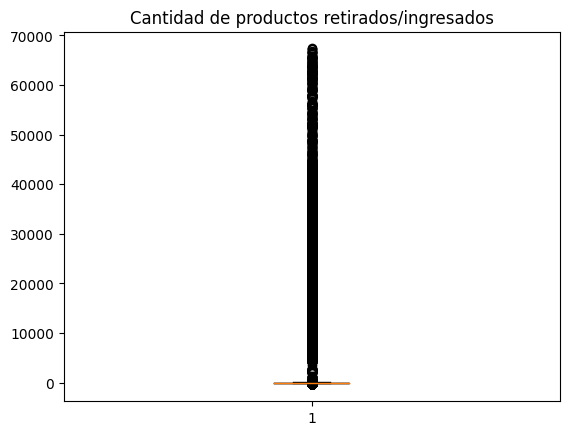

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de productos retirados/ingresados')
ax1.boxplot(np.array(movimientos.select('Cantidad').collect()))

Tenemos el siguiente diagrama de caja donde se observa claramente que tenemos un valor extremo en la variable cantidad y donde podemos ver los valores extremos o bigotes que determinan el punto de separación entre valores atípicos y normales, los valores atipicos, los cuartiles entre otros. Los productos retirados se encuentran **debajo del eje Y=0**  y los productos ingresados se que son en gran mayoria de datos **sobre del eje Y=0**

El análisis anterior es muy útil para variables de tipo numérico, sin embargo es incompleto para las variables de tipo caracter o las variables categoricas, por ende es necesario implementar nuestro propio código par obtener estadisticos como la moda y la mediana. A continuación obtenemos la moda para la variable FechaTransaccion:

In [87]:
movimientos.groupby("FechaTransaccion").count().orderBy("count", ascending=False).show(5)

+--------------------+-----+
|    FechaTransaccion|count|
+--------------------+-----+
|2015-11-03 12:00:...|  331|
|2015-01-21 12:00:...|  326|
|2015-04-14 12:00:...|  323|
|2016-05-04 12:00:...|  323|
|2015-10-06 12:00:...|  317|
+--------------------+-----+
only showing top 5 rows



## 4- Análisis de calidad de datos

A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

### 4.1- Completitud

In [101]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
        print('analizando columna: '+ c + ' - Cantidad de datos nulos: ' + str(vacios))
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [102]:
columnas_vacias_movimientos = contar_vacios(movimientos)

analizando columna: TransaccionProductoID - Cantidad de datos nulos: 0
analizando columna: ProductoID - Cantidad de datos nulos: 0
analizando columna: TipoTransaccionID - Cantidad de datos nulos: 0
analizando columna: ClienteID - Cantidad de datos nulos: 0
analizando columna: InvoiceID - Cantidad de datos nulos: 0
analizando columna: ProveedorID - Cantidad de datos nulos: 0
analizando columna: OrdenDeCompraID - Cantidad de datos nulos: 0
analizando columna: FechaTransaccion - Cantidad de datos nulos: 0
analizando columna: Cantidad - Cantidad de datos nulos: 0


In [104]:
columnas_alta_cardinalidad_movimientos = cardinalidad(movimientos)
columnas_alta_cardinalidad_movimientos

{'TransaccionProductoID': 173659}

Podemos notar que solo la colummna TransaccionProductoID posee una cardinalidad superior al 50%.

### 4.2- Unicidad y Validez

La unicidad se revisó en la tercera regla de negocio y la validez se reviso en el perfilamiento general, en la regla de negocio 3 y en el análisis de la descripción al final de la sección de revisión de reglas de negocio

### 4.3- Consistencia

A nivel de consistencia algunos ejemplos de revisión son fecahs de transaccion con diferentes formatos, los identificadores de cliente y de factura tienen valores **zero**. En nuestro caso vamos a verificar que todas los movimientos tengan fecha clientes asociados.

In [105]:
movimientos.groupby("InvoiceID").count().orderBy("count", ascending=False).show(5)

+---------+-----+
|InvoiceID|count|
+---------+-----+
|      0.0| 7156|
|  20518.0|    9|
|  23606.0|    9|
|  51395.0|    9|
|  37097.0|    9|
+---------+-----+
only showing top 5 rows



Como se puede observar existen 7156 movimientos con identificador de cliente **zero**.

## 5- Conclusiones/Resultados

**Conclusiones generales:**

1. En la tabla de movimientos tenemos información **relacionada con el cliente, el proveedor y con la factura**.
2. Una fila de movimientos representa **movimiento de retiro** de un producto realizado por un cliente o  **movimeinto de ingreso** de un producto realizado por un proveedor.
3. Existe una diferencia entre los movimientos y el numero de cliente.

**Conclusiones de reglas de negocio:**

1. La regla 1 no se puede determinar si es cierta o no, dado que no hay existe una tabla Invoice que nos brinde el monto asociado a cada movimiento.
2. La regla 1 no es cierta, dado que el numero de movimientos no coincide con los encontrados y no existe movimientos del año 2013.
3. Los datos comienzan en 31 de Diciembre del 2013, sin embargo existen datos nulos, ¿es un error o faltan datos?
4. La regla 4 no es cierta, dado que el numero de proveedores no coincide con lo indicado, adiconal a ello existen proveedores con valores de cadena vacia.

**Conclusiones de calidad:**

1. Las columnas CLienteID e InvoiceID tienen un conteo igual a 0, es decir es neesario re-validar esos datos ya que representan a identificador del cliente y la factura respectivamente.
2. El formato de la columna FechaTransaccion no es homogenea, es decir tienen distintos tipo de formatos. Por ejemplo (**Sep 30,2015** & **2015-11-03 12:00:05**).
3. Observamos que la columna CLienteID tiene 664 valores distintos, sin embargo se espearaba 228265 valores distintos.
4. Respecto a cardinalidad, solo la colummna TransaccionProductoID posee una cardinalidad superior al 50%.
5. Como se puede observar solo tenemos 3 proveedores vinculados a un moviimeintos, mientras que se esperaba tener 13 proveedores.

**Conclusiones de consultoria**

Teniendo en cuenta el requerimiento de WWI, consideramos que es posible llevar a cabo una solucióon pues contamos con la información necesaria especificada en el análisis requerido, sin embargo es necesario realizar correcciones a los datos y obtener aclaraciones de parte del negocio para entender completamente la necesidad de negocio